In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import librosa
import nltk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import re
from nltk.corpus import wordnet as wn
import torch
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, pipeline

2025-04-18 17:20:17.695320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744996817.914218      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744996817.980495      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Here the  automatic speech recognition (ASR) pipeline using Hugging Face’s transformers library  :
         - Transcribe .wav audio files to text.
         - Handle long audio clips with timestamps.
## used Whisper ASR model from Hugging Face  for speech transcription
         

In [4]:
# Load Whisper model from Hugging Face
AUDIO_MODEL = "openai/whisper-medium"
device = "mps" if torch.backends.mps.is_available() else "cpu"

speech_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    AUDIO_MODEL,
    torch_dtype=torch.float32,
).to(device)

processor = AutoProcessor.from_pretrained(AUDIO_MODEL)

asr_pipeline = pipeline(
    "automatic-speech-recognition",
    model=speech_model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch.float32,
    device=0 if torch.cuda.is_available() else -1)

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Device set to use cuda:0


## ** DEFINING cognitive indicators **

## HESITATION_MARKERS:
- A list of verbal fillers often associated with uncertainty, memory lapses, or speech planning.

- Excessive use may indicate cognitive load or early impairment.

In [5]:
HESITATION_MARKERS = ["uh", "um", "erm", "ah", "eh"] # hesitation markers

## compute_lexical_diversity(text)
- Lexical diversity = (unique words / total words)

- High values = varied vocabulary (good cognitive performance)

- Low values = repetitive or simple language (possible sign of decline)

In [6]:
def compute_lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words) if words else 0


## count_hesitations(text)
- Counts how many times the speaker uses filler words.

- Frequent hesitations may suggest processing delay, retrieval issues, or low confidence.

In [7]:
def count_hesitations(text):
    tokens = nltk.word_tokenize(text.lower())
    return sum(tokens.count(marker) for marker in HESITATION_MARKERS)

## compute_pitch_variability(y, sr)
- Calculates the standard deviation of pitch.

- Low pitch variability may reflect monotonic speech, a known trait in some cognitive or neurological conditions.

In [8]:
def compute_pitch_variability(y, sr):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[pitches > 0]
    return np.std(pitches) if len(pitches) > 0 else 0

# estimate_word_recall(transcript)
- Measures semantic vagueness — how often the speaker uses general or non-specific words.

- Also checks if these vague words appear in the semantic neighborhood of other words (using WordNet).

- High score = speaker may be struggling with precise word recall.

In [9]:
def estimate_word_recall(transcript):
    tokens = nltk.word_tokenize(transcript)
    synonyms_used = 0
    vague_terms = ["thing", "stuff", "it", "something"]
    vague_count = sum([transcript.lower().count(term) for term in vague_terms])
    for word in tokens:
        if wn.synsets(word):
            synonyms = wn.synsets(word)[0].lemma_names()
            if any(vague in synonyms for vague in vague_terms):
                synonyms_used += 1
    return vague_count + synonyms_used

# naming_task_score(transcript)
- Simulates a naming test (common in dementia screening).

- Measures how many target objects (e.g., from a picture) were successfully named.

- A low score may indicate semantic memory decline.

In [10]:
def naming_task_score(transcript):
    expected = ["apple", "banana", "chair", "pen"]
    found = sum(1 for word in expected if word in transcript.lower())
    return found / len(expected)

### Converting an audio file into a structured feature set that reflects both what was said (linguistic) and how it was said (acoustic), useful for cognitive health analysis.

#### Linguistic Features:
-Word & sentence count

- Average words per sentence

- Lexical diversity (unique words / total words)

- Hesitation count (e.g., “uh”, “um”)

- Word recall issues (e.g., “thing”, “stuff”)

- Naming task score (e.g., were expected words like “apple” said?)

#### Acoustic Features

- Tempo (speech speed)

- Zero crossing rate (signal variation)

- Energy (volume intensity)

- Spectral centroid (brightness of sound)

- Pitch variability

- MFCCs (phonetic fingerprint of the speech)


In [11]:
def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path)
        result = asr_pipeline(audio_path)
        transcript = result['text'].strip()

        word_count = len(nltk.word_tokenize(transcript))
        sent_count = len(nltk.sent_tokenize(transcript))
        avg_words_per_sent = word_count / sent_count if sent_count else 0
        lexical_diversity = compute_lexical_diversity(transcript)

        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        energy = np.mean(librosa.feature.rms(y=y))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        pitch_variability = compute_pitch_variability(y, sr)
        hesitation_count = count_hesitations(transcript)
        recall_score = estimate_word_recall(transcript)
        naming_score = naming_task_score(transcript)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        if len(mfcc_mean) < 13:
            mfcc_mean = np.pad(mfcc_mean, (0, 13 - len(mfcc_mean)), mode='constant')

        features = [
            word_count, sent_count, avg_words_per_sent, lexical_diversity,
            tempo, zcr, energy, spectral_centroid,
            pitch_variability, hesitation_count, recall_score, naming_score
        ] + list(mfcc_mean)

        features = list(map(float, features))
        print(f"{os.path.basename(audio_path)} → Feature length: {len(features)}")
        return features, transcript

    except Exception as e:
        print(f"Error extracting features from {audio_path}:\n{e}\n")
        return None, None

In [12]:
all_features = []
file_names = []
transcripts = []


In [16]:
AUDIO_DIR = "/kaggle/input/samples/samples"

In [17]:
for file in os.listdir(AUDIO_DIR):
    if file.endswith(".wav"):
        print(f"Processing: {file}")
        path = os.path.join(AUDIO_DIR, file)
        features, transcript = extract_features(path)
        if features is not None:
            all_features.append(features)
            file_names.append(file)
            transcripts.append(transcript)
        else:
            print(f"Skipped due to invalid features: {file}")


Processing: common_voice_en_40865482.wav


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name 

common_voice_en_40865482.wav → Feature length: 25
Processing: common_voice_en_40865484.wav


/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


common_voice_en_40865484.wav → Feature length: 25
Processing: common_voice_en_40865483.wav


/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


common_voice_en_40865483.wav → Feature length: 25
Processing: common_voice_en_40865481.wav


/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


common_voice_en_40865481.wav → Feature length: 25
Processing: common_voice_en_40865225.wav
common_voice_en_40865225.wav → Feature length: 25


/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))


In [18]:
X = np.array(all_features)
if X.size == 0 or X.ndim != 2:
    raise ValueError("Feature matrix X is empty or not 2D. Check your audio files or extraction logic.")

print("Feature matrix shape:", X.shape)

Feature matrix shape: (5, 25)


# USING pca+ clustering+ anomly detection

### `X`: feature matrix (1 row per audio file)

## Reduces feature matrix to 2D using PCA for visualization.

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


## Clusters the audio into 2 groups ( healthy vs at-risk).

In [20]:

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Flags potential anomalies — samples that are different from the rest

In [21]:
iso_forest = IsolationForest(contamination=0.2, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)

# VISUALIZATION

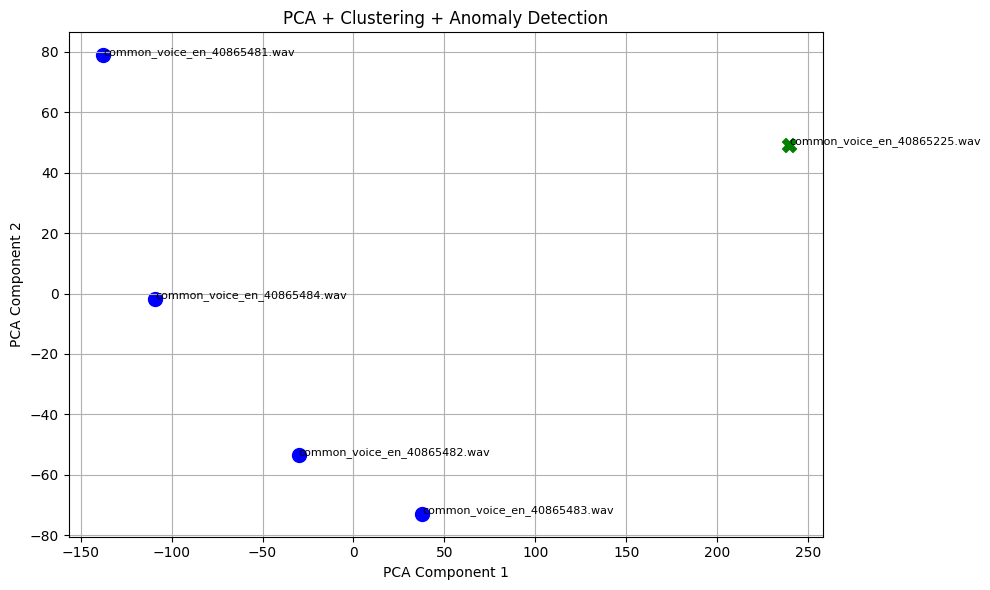

In [22]:
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 0 else 'green' for label in cluster_labels]
markers = ['o' if outlier == 1 else 'X' for outlier in anomaly_labels]

for i, (x, y) in enumerate(X_pca):
    plt.scatter(x, y, c=colors[i], marker=markers[i], s=100)
    plt.text(x + 0.1, y + 0.1, file_names[i], fontsize=8)

plt.title("PCA + Clustering + Anomaly Detection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# now testing on some more test datasets 

In [25]:
AUDIO_DIR = "/kaggle/input/test-data/test"

In [27]:
asr_pipeline = pipeline(
    "automatic-speech-recognition",
    model=speech_model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch.float32,
    return_timestamps=True,  # Important for long-form audio
    device=0 if torch.cuda.is_available() else -1
)

Device set to use cuda:0


In [28]:
for file in os.listdir(AUDIO_DIR):
    if file.endswith(".wav"):
        print(f"Processing: {file}")
        path = os.path.join(AUDIO_DIR, file)
        features, transcript = extract_features(path)
        if features is not None:
            all_features.append(features)
            file_names.append(file)
            transcripts.append(transcript)
        else:
            print(f"Skipped due to invalid features: {file}")

Processing: winston-churchill.wav


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))


winston-churchill.wav → Feature length: 25
Processing: harvard.wav


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))


harvard.wav → Feature length: 25
Processing: genevieve.wav


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


genevieve.wav → Feature length: 25


/tmp/ipykernel_31/2351800172.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = list(map(float, features))


In [29]:
X = np.array(all_features)
if X.size == 0 or X.ndim != 2:
    raise ValueError("Feature matrix X is empty or not 2D. Check your audio files or extraction logic.")

print("Feature matrix shape:", X.shape)

Feature matrix shape: (9, 25)


In [30]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


In [31]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
iso_forest = IsolationForest(contamination=0.2, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)

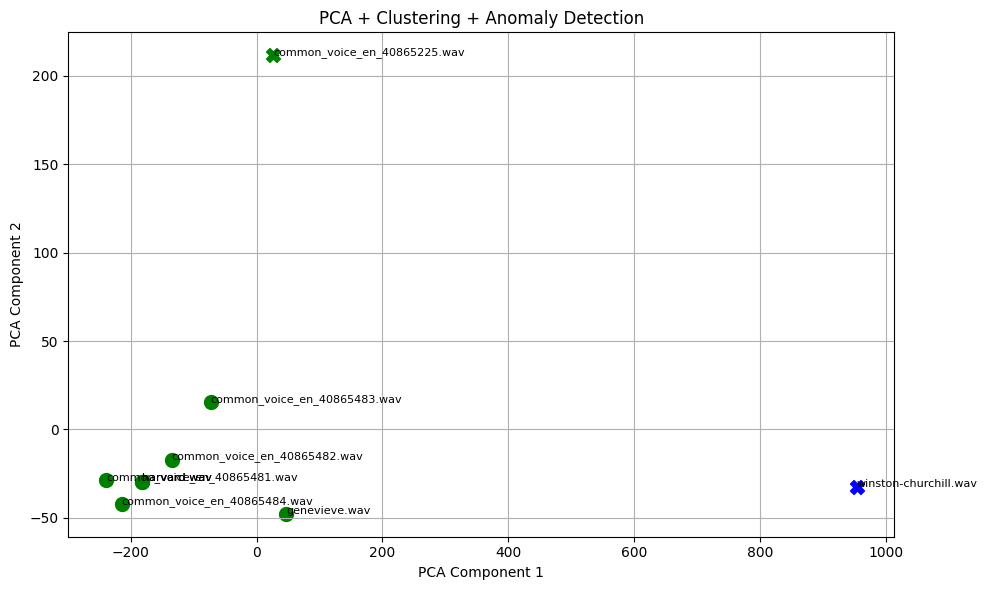

In [33]:
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 0 else 'green' for label in cluster_labels]
markers = ['o' if outlier == 1 else 'X' for outlier in anomaly_labels]

for i, (x, y) in enumerate(X_pca):
    plt.scatter(x, y, c=colors[i], marker=markers[i], s=100)
    plt.text(x + 0.1, y + 0.1, file_names[i], fontsize=8)

plt.title("PCA + Clustering + Anomaly Detection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()